In [1]:
# Common
import os
import cv2 
from tqdm import tqdm
import random
# data 
import numpy as np 
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt


# Model
import keras 
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow.image as tfi


In [33]:
def check(path):
    mask = load_image_tif(path)
    if mask is None:
        return (0, 0, 0, 0, 0)
    
    # Assuming mask is a 3D array
    mask = mask * 255
    occurrence = np.where((mask[:,:,0] * mask[:,:,1] * mask[:,:,2]) == (201 * 19 * 223))
    
    if len(occurrence[0]) == 0:
        return (0, 0, 0, 0, 0)
    
    ymin = np.sort(occurrence[0])[0] - 5
    ymax = np.sort(occurrence[0])[-1] + 5
    xmin = np.sort(occurrence[1])[0] - 5
    xmax = np.sort(occurrence[1])[-1] + 5
    
    return (1, xmin, ymin, xmax, ymax)

In [34]:
import os

def load_with_balls_images():
    images_path = []
    labels_path = []
    xy_xy = []

    # Path to the image directory
    image_dir = "/kaggle/working/converted_images"
    
    # Iterate over all files in the directory
    for path in os.listdir(image_dir):
        # Skip files that don't match the TIFF extension
        if path.endswith(".tif"):
            # Construct the full path for the image and label
            image_full_path = os.path.join(image_dir, path)
            label_full_path = os.path.join(image_dir, path.replace(".tif", "_fuse.png"))
            
            # Check and process the image
            val = check(image_full_path)
            xy_xy.append(val)
            images_path.append(image_full_path)
            labels_path.append(label_full_path)
    
    return images_path, labels_path, xy_xy

In [ ]:
import matplotlib.pyplot as plt
import random

def show(data, range_, xyxy=None):
    images, labels = data
    i = random.randint(0, range_ - 1)
    fig = plt.figure(figsize=(8, 9))
    
    # Load and show the image
    image = load_image(images[i])
    if image is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Image {i}")
    else:
        print(f"Cannot display image at index {i}")
        
    # If labels are provided, load and show the label mask
    if labels is not None:
        mask = load_image(labels[i])
        if mask is not None:
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"Label Mask {i}")
        else:
            print(f"Cannot display label mask at index {i}")
    
    plt.show()

# Usage example
for i in range(0, 5):
    show((images_path, labels_path), len(images_path), xyxy=None)


In [ ]:
def getxy_wh(xyxy):
    xywh = np.zeros((xyxy.shape[0], 4))  # Ensure correct shape
    xywh[:, 0] = (xyxy[:, 1] + xyxy[:, 3]) / 2  # x_center
    xywh[:, 1] = (xyxy[:, 2] + xyxy[:, 4]) / 2  # y_center
    xywh[:, 2] = xyxy[:, 3] - xyxy[:, 1]  # width
    xywh[:, 3] = xyxy[:, 4] - xyxy[:, 2]  # height
    return xywh

In [ ]:
def load_data_ball():
    images = []
    for image_path in images_path:
        images.append(load_image(image_path))  # Corrected from labels_path to images_path
    
    return np.array(images), getxy_wh(np.array(xyxy))


In [ ]:
def load_all_data():
    images = []
    labels = []
    for image_path, label_path in zip(images_path, labels_path):
        images.append(load_image(image_path))
        labels.append(load_image(label_path))
    return np.array(images), np.array(labels)


In [ ]:
import rasterio as rio
import folium
from skimage.io import imread
image = imread('/kaggle/input/segemantation/data/images/10.tif')
print (image.shape)
plt.imshow(image[:,:,11],cmap=None)#Chute mandei bem it was [:,:,0]
plt.axes = False
plt.title("Raster Bio 13 France");

In [ ]:

from skimage.io import imread
image = imread('/kaggle/input/segemantation/data/images/105.tif')
print (image.shape)
plt.imshow(image[:,:,4], cmap = 'ocean') #it was [:,:,0] 3D
plt.axes = False
plt.title("Raster Bio 4 USA");

In [2]:
def show_image(image, cmap=None, title=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [3]:
import os

image_path = '/kaggle/input/segemantation/data/images'
mask_path = '/kaggle/input/segemantation/data/labels'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

# Function to extract common identifier (assuming numeric part of the filename)
def extract_identifier(filename):
    return os.path.splitext(filename)[0].split('_')[0]  # Adjust this split according to your filenames

# Create a dictionary with the identifier as the key
image_dict = {extract_identifier(name): name for name in image_names}
mask_dict = {extract_identifier(name): name for name in mask_names}

# Find matching and mismatched pairs
matching_pairs = []
mismatches = []

for key in image_dict:
    if key in mask_dict:
        matching_pairs.append((image_dict[key], mask_dict[key]))
    else:
        mismatches.append((image_dict[key], None))

for key in mask_dict:
    if key not in image_dict:
        mismatches.append((None, mask_dict[key]))

if mismatches:
    print("Images and Masks do not match!")
    print("Mismatches:", mismatches)
else:
    print("Image and Mask are correctly matched!")


Image and Mask are correctly matched!


In [4]:
import imageio
import numpy as np
import os
from tqdm import tqdm

input_dir = '/kaggle/input/segemantation/data/images/'
output_dir = '/kaggle/working/converted_images/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def process_image(img, output_path):
    # Normalize image data if necessary
    img = img.astype(np.float32) / np.max(img)
    
    # Example: Combine the first 3 channels to create an RGB image
    if img.shape[-1] >= 3:
        rgb_img = img[..., :3]  # Take the first 3 channels
        rgb_img = (rgb_img * 255).astype(np.uint8)
        imageio.imwrite(output_path, rgb_img)
    else:
        # Handle cases with fewer than 3 channels or save as-is
        imageio.imwrite(output_path, img)

for filename in tqdm(os.listdir(input_dir), desc="Converting"):
    if filename.endswith('.tif'):
        img_path = os.path.join(input_dir, filename)
        try:
            # Read the multi-channel TIFF image
            img = imageio.imread(img_path)
            
            # Prepare the output path for RGB image
            new_filename = os.path.splitext(filename)[0] + '_rgb.png'
            output_path = os.path.join(output_dir, new_filename)
            
            # Process and save the image
            process_image(img, output_path)
            print(f"Converted: {filename} -> {new_filename}")
        
        except Exception as e:
            print(f"Failed to convert {filename}: {e}")

print("Conversion complete.")


Converting:   0%|          | 0/306 [00:00<?, ?it/s]/tmp/ipykernel_36/591216832.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
Converting:   2%|▏         | 6/306 [00:00<00:16, 18.44it/s]

Converted: 274.tif -> 274_rgb.png
Converted: 123.tif -> 123_rgb.png
Converted: 130.tif -> 130_rgb.png
Converted: 170.tif -> 170_rgb.png
Converted: 66.tif -> 66_rgb.png
Converted: 296.tif -> 296_rgb.png
Converted: 215.tif -> 215_rgb.png
Converted: 116.tif -> 116_rgb.png
Converted: 204.tif -> 204_rgb.png
Converted: 171.tif -> 171_rgb.png


Converting:   6%|▌         | 17/306 [00:00<00:08, 34.74it/s]

Converted: 18.tif -> 18_rgb.png
Converted: 232.tif -> 232_rgb.png
Converted: 168.tif -> 168_rgb.png
Converted: 125.tif -> 125_rgb.png
Converted: 216.tif -> 216_rgb.png
Converted: 233.tif -> 233_rgb.png
Converted: 94.tif -> 94_rgb.png
Converted: 86.tif -> 86_rgb.png
Converted: 256.tif -> 256_rgb.png


Converting:   9%|▉         | 27/306 [00:00<00:06, 40.80it/s]

Converted: 46.tif -> 46_rgb.png
Converted: 136.tif -> 136_rgb.png
Converted: 208.tif -> 208_rgb.png
Converted: 245.tif -> 245_rgb.png
Converted: 45.tif -> 45_rgb.png
Converted: 148.tif -> 148_rgb.png
Converted: 254.tif -> 254_rgb.png
Converted: 276.tif -> 276_rgb.png
Converted: 79.tif -> 79_rgb.png
Converted: 197.tif -> 197_rgb.png


Converting:  12%|█▏        | 37/306 [00:01<00:06, 44.07it/s]

Converted: 164.tif -> 164_rgb.png
Converted: 17.tif -> 17_rgb.png
Converted: 5.tif -> 5_rgb.png
Converted: 90.tif -> 90_rgb.png
Converted: 161.tif -> 161_rgb.png
Converted: 2.tif -> 2_rgb.png
Converted: 278.tif -> 278_rgb.png
Converted: 96.tif -> 96_rgb.png
Converted: 29.tif -> 29_rgb.png
Converted: 68.tif -> 68_rgb.png


Converting:  15%|█▌        | 47/306 [00:01<00:05, 45.38it/s]

Converted: 100.tif -> 100_rgb.png
Converted: 250.tif -> 250_rgb.png
Converted: 252.tif -> 252_rgb.png
Converted: 300.tif -> 300_rgb.png
Converted: 104.tif -> 104_rgb.png
Converted: 103.tif -> 103_rgb.png
Converted: 19.tif -> 19_rgb.png
Converted: 38.tif -> 38_rgb.png
Converted: 15.tif -> 15_rgb.png
Converted: 202.tif -> 202_rgb.png


Converting:  19%|█▊        | 57/306 [00:01<00:05, 46.99it/s]

Converted: 114.tif -> 114_rgb.png
Converted: 271.tif -> 271_rgb.png
Converted: 50.tif -> 50_rgb.png
Converted: 247.tif -> 247_rgb.png
Converted: 139.tif -> 139_rgb.png
Converted: 230.tif -> 230_rgb.png
Converted: 221.tif -> 221_rgb.png
Converted: 126.tif -> 126_rgb.png
Converted: 25.tif -> 25_rgb.png
Converted: 194.tif -> 194_rgb.png


Converting:  22%|██▏       | 67/306 [00:01<00:05, 46.48it/s]

Converted: 78.tif -> 78_rgb.png
Converted: 81.tif -> 81_rgb.png
Converted: 212.tif -> 212_rgb.png
Converted: 92.tif -> 92_rgb.png
Converted: 147.tif -> 147_rgb.png
Converted: 31.tif -> 31_rgb.png
Converted: 191.tif -> 191_rgb.png
Converted: 106.tif -> 106_rgb.png
Converted: 244.tif -> 244_rgb.png
Converted: 80.tif -> 80_rgb.png


Converting:  25%|██▌       | 77/306 [00:01<00:04, 46.27it/s]

Converted: 61.tif -> 61_rgb.png
Converted: 49.tif -> 49_rgb.png
Converted: 257.tif -> 257_rgb.png
Converted: 255.tif -> 255_rgb.png
Converted: 117.tif -> 117_rgb.png
Converted: 289.tif -> 289_rgb.png
Converted: 193.tif -> 193_rgb.png
Converted: 13.tif -> 13_rgb.png
Converted: 174.tif -> 174_rgb.png
Converted: 220.tif -> 220_rgb.png


Converting:  28%|██▊       | 87/306 [00:02<00:04, 45.44it/s]

Converted: 281.tif -> 281_rgb.png
Converted: 112.tif -> 112_rgb.png
Converted: 143.tif -> 143_rgb.png
Converted: 239.tif -> 239_rgb.png
Converted: 214.tif -> 214_rgb.png
Converted: 24.tif -> 24_rgb.png
Converted: 23.tif -> 23_rgb.png
Converted: 285.tif -> 285_rgb.png
Converted: 155.tif -> 155_rgb.png
Converted: 198.tif -> 198_rgb.png


Converting:  32%|███▏      | 97/306 [00:02<00:04, 45.48it/s]

Converted: 40.tif -> 40_rgb.png
Converted: 302.tif -> 302_rgb.png
Converted: 108.tif -> 108_rgb.png
Converted: 288.tif -> 288_rgb.png
Converted: 236.tif -> 236_rgb.png
Converted: 131.tif -> 131_rgb.png
Converted: 39.tif -> 39_rgb.png
Converted: 85.tif -> 85_rgb.png
Converted: 55.tif -> 55_rgb.png
Converted: 10.tif -> 10_rgb.png


Converting:  35%|███▌      | 108/306 [00:02<00:04, 47.27it/s]

Converted: 30.tif -> 30_rgb.png
Converted: 258.tif -> 258_rgb.png
Converted: 76.tif -> 76_rgb.png
Converted: 47.tif -> 47_rgb.png
Converted: 150.tif -> 150_rgb.png
Converted: 298.tif -> 298_rgb.png
Converted: 16.tif -> 16_rgb.png
Converted: 134.tif -> 134_rgb.png
Converted: 200.tif -> 200_rgb.png
Converted: 267.tif -> 267_rgb.png


Converting:  39%|███▊      | 118/306 [00:02<00:04, 46.98it/s]

Converted: 3.tif -> 3_rgb.png
Converted: 67.tif -> 67_rgb.png
Converted: 4.tif -> 4_rgb.png
Converted: 115.tif -> 115_rgb.png
Converted: 305.tif -> 305_rgb.png
Converted: 97.tif -> 97_rgb.png
Converted: 22.tif -> 22_rgb.png
Converted: 0.tif -> 0_rgb.png
Converted: 98.tif -> 98_rgb.png
Converted: 77.tif -> 77_rgb.png


Converting:  42%|████▏     | 128/306 [00:03<00:03, 47.45it/s]

Converted: 297.tif -> 297_rgb.png
Converted: 242.tif -> 242_rgb.png
Converted: 87.tif -> 87_rgb.png
Converted: 260.tif -> 260_rgb.png
Converted: 301.tif -> 301_rgb.png
Converted: 129.tif -> 129_rgb.png
Converted: 190.tif -> 190_rgb.png
Converted: 177.tif -> 177_rgb.png
Converted: 185.tif -> 185_rgb.png
Converted: 101.tif -> 101_rgb.png


Converting:  45%|████▌     | 139/306 [00:03<00:03, 47.11it/s]

Converted: 42.tif -> 42_rgb.png
Converted: 12.tif -> 12_rgb.png
Converted: 227.tif -> 227_rgb.png
Converted: 151.tif -> 151_rgb.png
Converted: 74.tif -> 74_rgb.png
Converted: 180.tif -> 180_rgb.png
Converted: 95.tif -> 95_rgb.png
Converted: 75.tif -> 75_rgb.png
Converted: 237.tif -> 237_rgb.png
Converted: 187.tif -> 187_rgb.png


Converting:  49%|████▊     | 149/306 [00:03<00:03, 47.07it/s]

Converted: 154.tif -> 154_rgb.png
Converted: 122.tif -> 122_rgb.png
Converted: 105.tif -> 105_rgb.png
Converted: 261.tif -> 261_rgb.png
Converted: 243.tif -> 243_rgb.png
Converted: 172.tif -> 172_rgb.png
Converted: 275.tif -> 275_rgb.png
Converted: 163.tif -> 163_rgb.png
Converted: 240.tif -> 240_rgb.png
Converted: 262.tif -> 262_rgb.png


Converting:  52%|█████▏    | 159/306 [00:03<00:03, 46.77it/s]

Converted: 58.tif -> 58_rgb.png
Converted: 83.tif -> 83_rgb.png
Converted: 182.tif -> 182_rgb.png
Converted: 272.tif -> 272_rgb.png
Converted: 249.tif -> 249_rgb.png
Converted: 246.tif -> 246_rgb.png
Converted: 152.tif -> 152_rgb.png
Converted: 268.tif -> 268_rgb.png
Converted: 113.tif -> 113_rgb.png
Converted: 162.tif -> 162_rgb.png


Converting:  55%|█████▌    | 169/306 [00:03<00:02, 47.56it/s]

Converted: 226.tif -> 226_rgb.png
Converted: 28.tif -> 28_rgb.png
Converted: 84.tif -> 84_rgb.png
Converted: 36.tif -> 36_rgb.png
Converted: 60.tif -> 60_rgb.png
Converted: 219.tif -> 219_rgb.png
Converted: 179.tif -> 179_rgb.png
Converted: 273.tif -> 273_rgb.png
Converted: 56.tif -> 56_rgb.png
Converted: 223.tif -> 223_rgb.png


Converting:  58%|█████▊    | 179/306 [00:04<00:02, 47.64it/s]

Converted: 225.tif -> 225_rgb.png
Converted: 184.tif -> 184_rgb.png
Converted: 59.tif -> 59_rgb.png
Converted: 63.tif -> 63_rgb.png
Converted: 57.tif -> 57_rgb.png
Converted: 145.tif -> 145_rgb.png
Converted: 166.tif -> 166_rgb.png
Converted: 146.tif -> 146_rgb.png
Converted: 149.tif -> 149_rgb.png
Converted: 99.tif -> 99_rgb.png


Converting:  62%|██████▏   | 189/306 [00:04<00:02, 47.65it/s]

Converted: 304.tif -> 304_rgb.png
Converted: 299.tif -> 299_rgb.png
Converted: 217.tif -> 217_rgb.png
Converted: 303.tif -> 303_rgb.png
Converted: 110.tif -> 110_rgb.png
Converted: 235.tif -> 235_rgb.png
Converted: 69.tif -> 69_rgb.png
Converted: 222.tif -> 222_rgb.png
Converted: 93.tif -> 93_rgb.png
Converted: 159.tif -> 159_rgb.png


Converting:  65%|██████▌   | 199/306 [00:04<00:02, 47.02it/s]

Converted: 132.tif -> 132_rgb.png
Converted: 282.tif -> 282_rgb.png
Converted: 265.tif -> 265_rgb.png
Converted: 144.tif -> 144_rgb.png
Converted: 21.tif -> 21_rgb.png
Converted: 283.tif -> 283_rgb.png
Converted: 7.tif -> 7_rgb.png
Converted: 189.tif -> 189_rgb.png
Converted: 259.tif -> 259_rgb.png
Converted: 295.tif -> 295_rgb.png


Converting:  67%|██████▋   | 204/306 [00:04<00:02, 46.66it/s]

Converted: 178.tif -> 178_rgb.png
Converted: 37.tif -> 37_rgb.png
Converted: 207.tif -> 207_rgb.png
Converted: 54.tif -> 54_rgb.png
Converted: 210.tif -> 210_rgb.png
Converted: 287.tif -> 287_rgb.png
Converted: 203.tif -> 203_rgb.png
Converted: 229.tif -> 229_rgb.png
Converted: 165.tif -> 165_rgb.png
Converted: 26.tif -> 26_rgb.png


Converting:  70%|███████   | 215/306 [00:04<00:01, 47.52it/s]

Converted: 72.tif -> 72_rgb.png
Converted: 175.tif -> 175_rgb.png
Converted: 294.tif -> 294_rgb.png
Converted: 192.tif -> 192_rgb.png
Converted: 41.tif -> 41_rgb.png
Converted: 14.tif -> 14_rgb.png
Converted: 183.tif -> 183_rgb.png
Converted: 293.tif -> 293_rgb.png
Converted: 209.tif -> 209_rgb.png
Converted: 71.tif -> 71_rgb.png


Converting:  74%|███████▎  | 225/306 [00:05<00:01, 47.37it/s]

Converted: 118.tif -> 118_rgb.png
Converted: 292.tif -> 292_rgb.png
Converted: 158.tif -> 158_rgb.png
Converted: 201.tif -> 201_rgb.png
Converted: 279.tif -> 279_rgb.png
Converted: 119.tif -> 119_rgb.png
Converted: 34.tif -> 34_rgb.png
Converted: 127.tif -> 127_rgb.png
Converted: 82.tif -> 82_rgb.png
Converted: 269.tif -> 269_rgb.png


Converting:  77%|███████▋  | 235/306 [00:05<00:01, 46.61it/s]

Converted: 224.tif -> 224_rgb.png
Converted: 284.tif -> 284_rgb.png
Converted: 199.tif -> 199_rgb.png
Converted: 286.tif -> 286_rgb.png
Converted: 173.tif -> 173_rgb.png
Converted: 266.tif -> 266_rgb.png
Converted: 218.tif -> 218_rgb.png
Converted: 65.tif -> 65_rgb.png
Converted: 228.tif -> 228_rgb.png
Converted: 20.tif -> 20_rgb.png


Converting:  80%|████████  | 245/306 [00:05<00:01, 46.21it/s]

Converted: 176.tif -> 176_rgb.png
Converted: 89.tif -> 89_rgb.png
Converted: 169.tif -> 169_rgb.png
Converted: 107.tif -> 107_rgb.png
Converted: 48.tif -> 48_rgb.png
Converted: 156.tif -> 156_rgb.png
Converted: 32.tif -> 32_rgb.png
Converted: 140.tif -> 140_rgb.png
Converted: 44.tif -> 44_rgb.png
Converted: 1.tif -> 1_rgb.png


Converting:  83%|████████▎ | 255/306 [00:05<00:01, 44.88it/s]

Converted: 206.tif -> 206_rgb.png
Converted: 35.tif -> 35_rgb.png
Converted: 141.tif -> 141_rgb.png
Converted: 88.tif -> 88_rgb.png
Converted: 270.tif -> 270_rgb.png
Converted: 238.tif -> 238_rgb.png
Converted: 6.tif -> 6_rgb.png
Converted: 51.tif -> 51_rgb.png
Converted: 121.tif -> 121_rgb.png
Converted: 124.tif -> 124_rgb.png


Converting:  87%|████████▋ | 265/306 [00:05<00:00, 45.51it/s]

Converted: 291.tif -> 291_rgb.png
Converted: 241.tif -> 241_rgb.png
Converted: 70.tif -> 70_rgb.png
Converted: 153.tif -> 153_rgb.png
Converted: 33.tif -> 33_rgb.png
Converted: 133.tif -> 133_rgb.png
Converted: 160.tif -> 160_rgb.png
Converted: 27.tif -> 27_rgb.png
Converted: 9.tif -> 9_rgb.png


Converting:  90%|████████▉ | 275/306 [00:06<00:00, 45.43it/s]

Converted: 142.tif -> 142_rgb.png
Converted: 196.tif -> 196_rgb.png
Converted: 263.tif -> 263_rgb.png
Converted: 109.tif -> 109_rgb.png
Converted: 64.tif -> 64_rgb.png
Converted: 280.tif -> 280_rgb.png
Converted: 231.tif -> 231_rgb.png
Converted: 111.tif -> 111_rgb.png
Converted: 138.tif -> 138_rgb.png
Converted: 167.tif -> 167_rgb.png


Converting:  93%|█████████▎| 285/306 [00:06<00:00, 45.89it/s]

Converted: 211.tif -> 211_rgb.png
Converted: 248.tif -> 248_rgb.png
Converted: 213.tif -> 213_rgb.png
Converted: 53.tif -> 53_rgb.png
Converted: 195.tif -> 195_rgb.png
Converted: 157.tif -> 157_rgb.png
Converted: 62.tif -> 62_rgb.png
Converted: 11.tif -> 11_rgb.png
Converted: 91.tif -> 91_rgb.png
Converted: 188.tif -> 188_rgb.png


Converting:  96%|█████████▋| 295/306 [00:06<00:00, 46.27it/s]

Converted: 234.tif -> 234_rgb.png
Converted: 135.tif -> 135_rgb.png
Converted: 186.tif -> 186_rgb.png
Converted: 277.tif -> 277_rgb.png
Converted: 52.tif -> 52_rgb.png
Converted: 264.tif -> 264_rgb.png
Converted: 253.tif -> 253_rgb.png
Converted: 73.tif -> 73_rgb.png
Converted: 181.tif -> 181_rgb.png
Converted: 8.tif -> 8_rgb.png


Converting: 100%|██████████| 306/306 [00:06<00:00, 44.84it/s]

Converted: 120.tif -> 120_rgb.png
Converted: 102.tif -> 102_rgb.png
Converted: 290.tif -> 290_rgb.png
Converted: 205.tif -> 205_rgb.png
Converted: 137.tif -> 137_rgb.png
Converted: 43.tif -> 43_rgb.png
Converted: 128.tif -> 128_rgb.png
Converted: 251.tif -> 251_rgb.png
Conversion complete.


In [10]:
import numpy as np
import cv2 as cv
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import os

# Define paths
image_path = '/kaggle/working/converted_images/'
mask_path = '/kaggle/input/segemantation/data/labels/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

# Filter masks to include only those that match images
valid_masks = [name for name in mask_names if name in image_names]

# Initialize arrays for images and masks
images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names), SIZE, SIZE, 1))

# Load images
for id, image_name in tqdm(enumerate(image_names), desc="Loading Images", total=len(image_names)):
    path = os.path.join(image_path, image_name)
    img = img_to_array(load_img(path)).astype('float') / 255.
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img

# Load masks
for id, mask_name in tqdm(enumerate(valid_masks), desc="Loading Masks", total=len(valid_masks)):
    path = os.path.join(mask_path, mask_name)
    mask = img_to_array(load_img(path, color_mode='grayscale')).astype('float') / 255.
    mask = cv.resize(mask, (SIZE, SIZE), cv.INTER_AREA)
    masks[id] = mask


Loading Images: 100%|██████████| 306/306 [00:00<00:00, 789.43it/s]
Loading Masks: 0it [00:00, ?it/s]


In [11]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = img_to_array(load_img(path)).astype('float')/255.
    img = cv2.resize(img, (SIZE,SIZE), cv2.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = img_to_array(load_img(path)).astype('float')/255.
    mask = cv2.resize(mask, (SIZE,SIZE), cv2.INTER_AREA)
    masks[id] = mask[:,:,:1]

Mask:  67%|██████▋   | 306/456 [00:00<00:00, 830.44it/s]


IndexError: index 306 is out of bounds for axis 0 with size 306

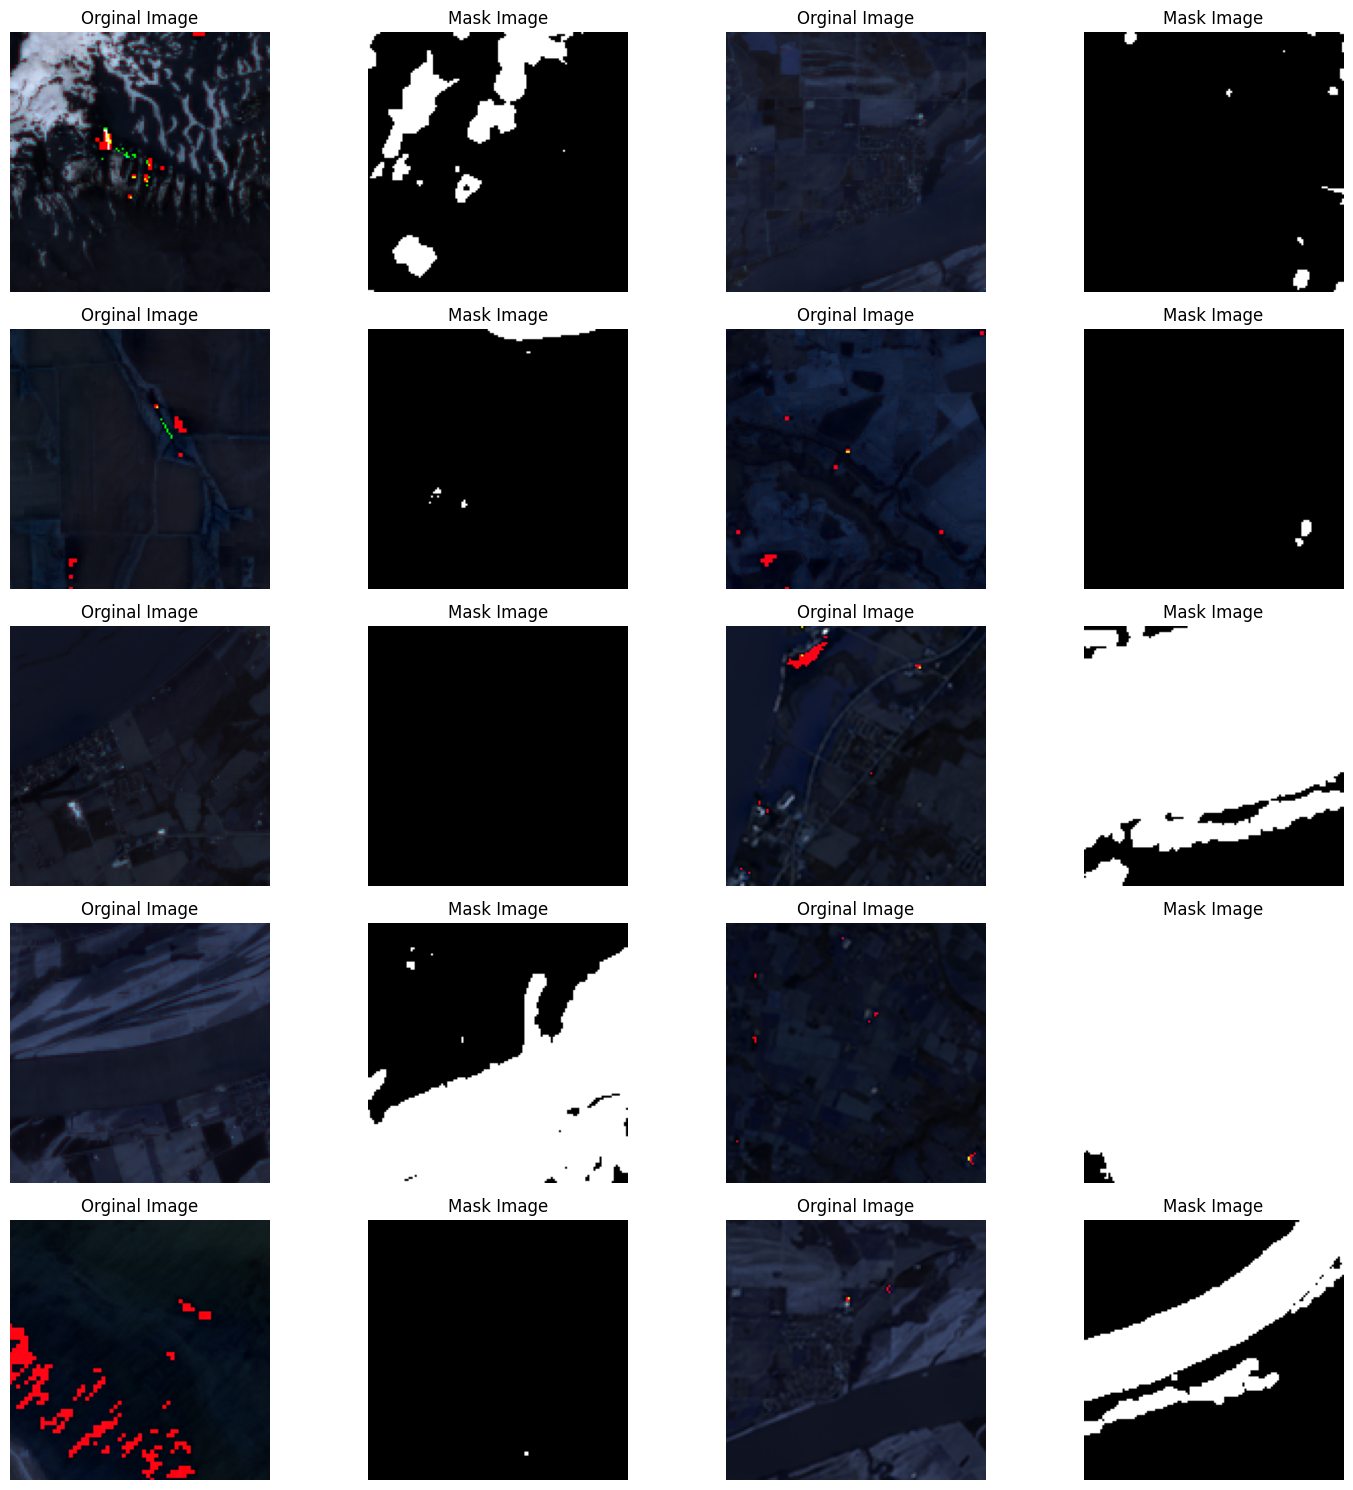

In [12]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)

    if i%2!=0:
        id = np.random.randint(len(images))
        show_image(images[id], title="Orginal Image")
    elif i%2==0:
        show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

In [13]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [14]:

# Contraction
class EncoderBlock(keras.layers.Layer):
    def __init__(self, filters, rate=None, pooling=True):
        super(EncoderBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.conv1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        if self.pooling: self.pool = MaxPool2D(pool_size=(2,2))
        if self.rate is not None: self.drop = Dropout(rate)
    
    def call(self, inputs):
        x = self.conv1(inputs)
        if self.rate is not None: x = self.drop(x)
        x = self.conv2(x)
        if self.pooling: 
            y = self.pool(x)
            return y, x
        else:
            return x
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters": self.filters,
            "rate": self.rate,
            "pooling": self.pooling
        }

# Expansion
class DecoderBlock(keras.layers.Layer):
    def __init__(self, filters, rate=None, axis=-1):
        super(DecoderBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.axis = axis
        self.convT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding='same')
        self.conv1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
        if rate is not None: self.drop = Dropout(self.rate)
        self.conv2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    
    def call(self, inputs):
        X, short_X = inputs
        ct = self.convT(X)
        c_ = concatenate([ct, short_X], axis=self.axis)
        x = self.conv1(c_)
        if self.rate is not None: x = self.drop(x)
        y = self.conv2(x)
        return y
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters": self.filters,
            "rate": self.rate,
            "axis": self.axis,
        }

# Callback 
class ShowProgress(keras.callbacks.Callback):
    def __init__(self, save=False):
        super(ShowProgress, self).__init__()
        self.save = save
    
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis, ...]
        pred_mask = self.model.predict(real_img).reshape(SIZE, SIZE)
        proc_mask1 = post_process(pred_mask, threshold=0.4)
        proc_mask2 = post_process(pred_mask, threshold=0.5)
        proc_mask3 = post_process(pred_mask, threshold=0.9)
        mask = masks[id].reshape(SIZE, SIZE)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 6, 1)
        show_image(real_img[0], title="Original Image")

        plt.subplot(1, 6, 2)
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        
        plt.subplot(1, 6, 3)
        show_image(mask, title="Original Mask", cmap='gray')

        plt.subplot(1, 6, 4)
        show_image(proc_mask1, title="Processed @0.4", cmap='gray')

        plt.subplot(1, 6, 5)
        show_image(proc_mask2, title="Processed @0.5", cmap='gray')

        plt.subplot(1, 6, 6)
        show_image(proc_mask3, title="Processed @0.9", cmap='gray')

        plt.tight_layout()
        if self.save:
            plt.savefig(f"Progress-{epoch+1}.png")
        plt.show()

# Post Process
def post_process(image, threshold=0.4):
    return (image > threshold).astype(np.uint8)

# Make sure to define `show_image` function if it's not defined yet
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')


In [15]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [16]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.keras', save_best_only=True),  # Use .keras extension
    ShowProgress(save=True)
]


In [18]:
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block       │ [(None, 64, 64,   │      2,768 │ input_layer[0][0] │
│ (EncoderBlock)      │ 16), (None, 128,  │            │                   │
│                     │ 128, 16)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_1     │ [(None, 32, 32,   │     13,888 │ encoder_block[0]… │
│ (EncoderBlock)      │ 32), (None, 64,   │            │                   │
│                     │ 64, 32)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_2     │ [(None, 16, 16,   │     55,424 │ encoder_block_1[… │
│ (EncoderBlock)      │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_3     │ [(None, 8, 8,     │    221,440 │ encoder_block_2[… │
│ (EncoderBlock)      │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_4     │ (None, 8, 8, 256) │    885,248 │ encoder_block_3[… │
│ (EncoderBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block       │ (None, 16, 16,    │    737,664 │ encoder_block_4[… │
│ (DecoderBlock)      │ 128)              │            │ encoder_block_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_1     │ (None, 32, 32,    │    184,512 │ decoder_block[0]… │
│ (DecoderBlock)      │ 64)               │            │ encoder_block_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_2     │ (None, 64, 64,    │     46,176 │ decoder_block_1[… │
│ (DecoderBlock)      │ 32)               │            │ encoder_block_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_3     │ (None, 128, 128,  │     11,568 │ decoder_block_2[… │
│ (DecoderBlock)      │ 16)               │            │ encoder_block[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │         17 │ decoder_block_3[… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1725459490.665764     118 service.cc:145] XLA service 0x7ecbac00fd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725459490.665826     118 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0818 - loss: 0.7451

I0000 00:00:1725459510.259941     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepep - accuracy: 0.2603 - loss: 0.6679 


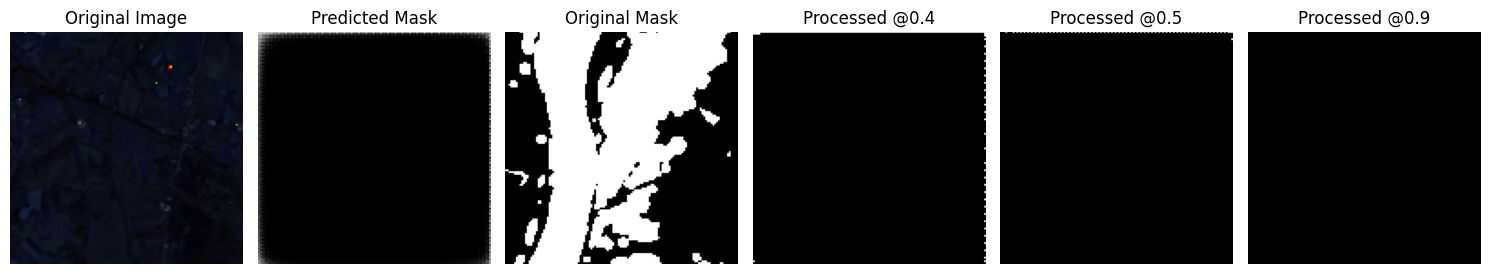

16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2703 - loss: 0.6591 - val_accuracy: 0.7241 - val_loss: 0.0339
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepep - accuracy: 0.6552 - loss: 0.077


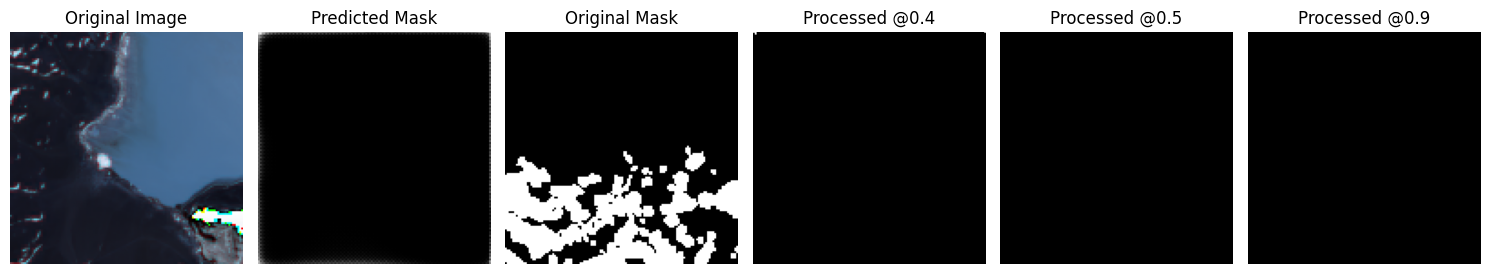

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6568 - loss: 0.0760 - val_accuracy: 0.7268 - val_loss: 0.0309
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.6675 - loss: 0.025


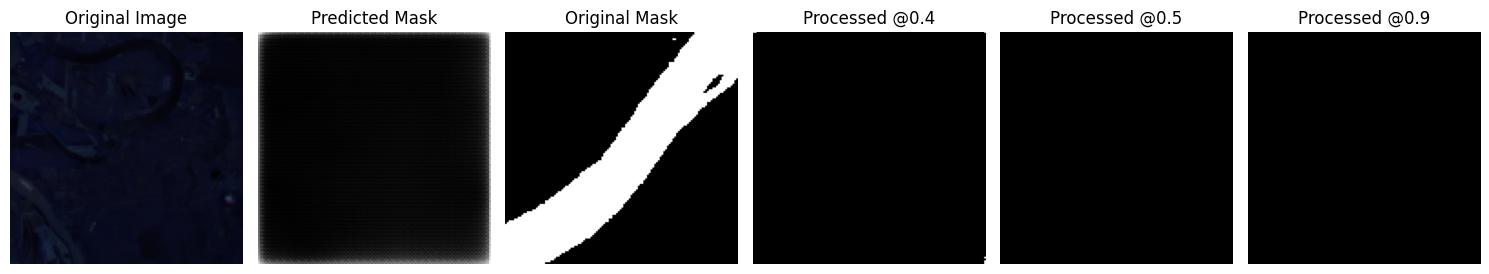

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.6685 - loss: 0.0255 - val_accuracy: 0.7268 - val_loss: 0.0233
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.6673 - loss: 0.017


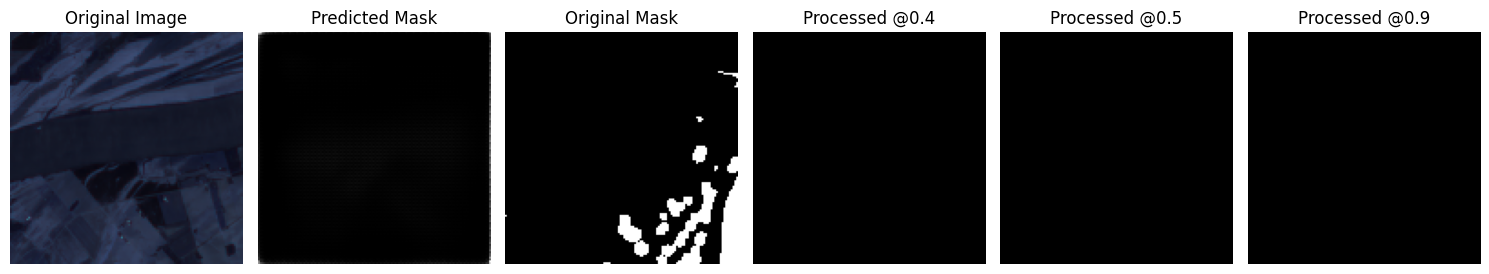

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6683 - loss: 0.0177 - val_accuracy: 0.7268 - val_loss: 0.0160
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.6523 - loss: 0.015


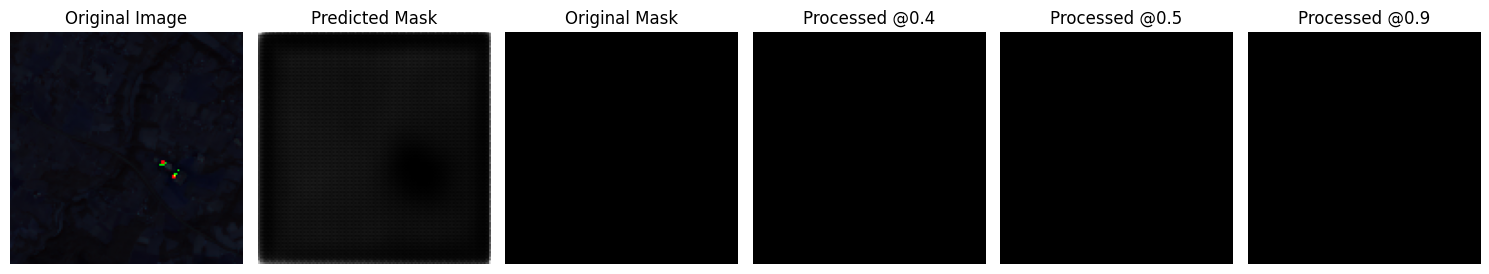

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6560 - loss: 0.0149 - val_accuracy: 0.7268 - val_loss: 0.0158
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.6694 - loss: 0.013


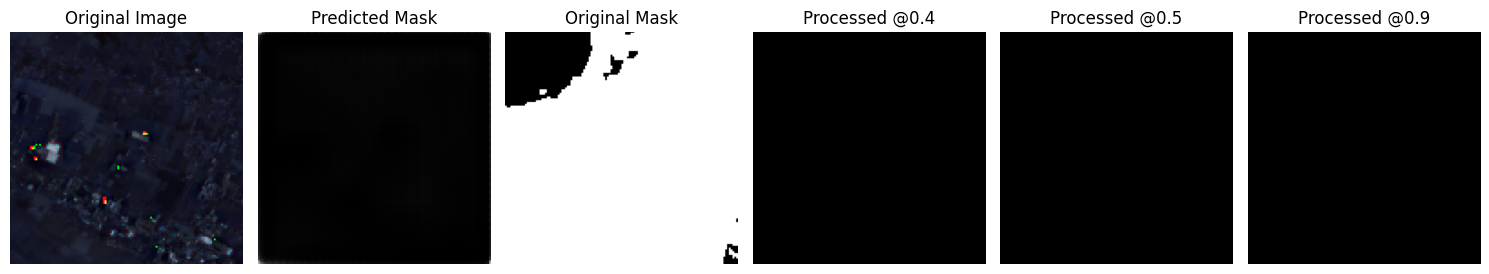

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6703 - loss: 0.0130 - val_accuracy: 0.7268 - val_loss: 0.0107
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepep - accuracy: 0.6546 - loss: 0.012


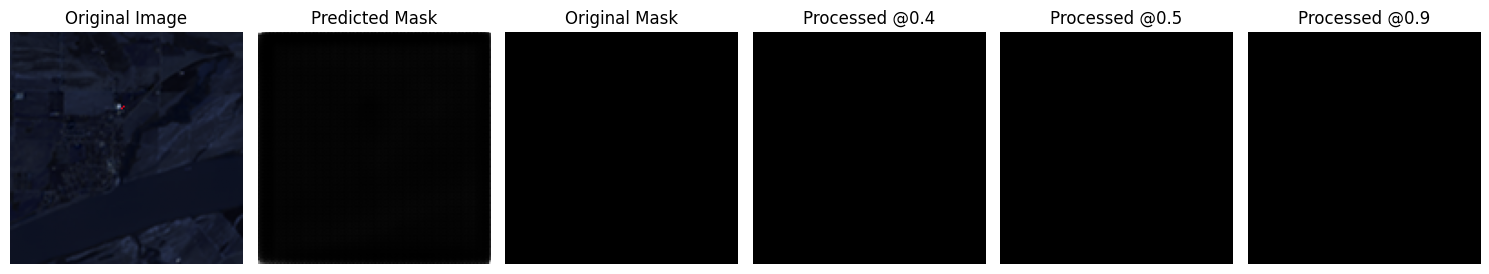

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6564 - loss: 0.0127 - val_accuracy: 0.7268 - val_loss: 0.0098
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.7128 - loss: 0.010


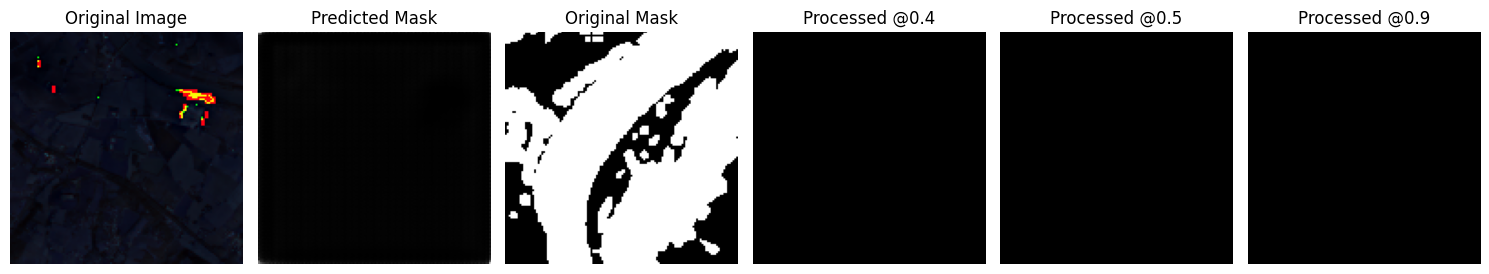

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7094 - loss: 0.0105 - val_accuracy: 0.7268 - val_loss: 0.0090
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - accuracy: 0.6979 - loss: 0.010


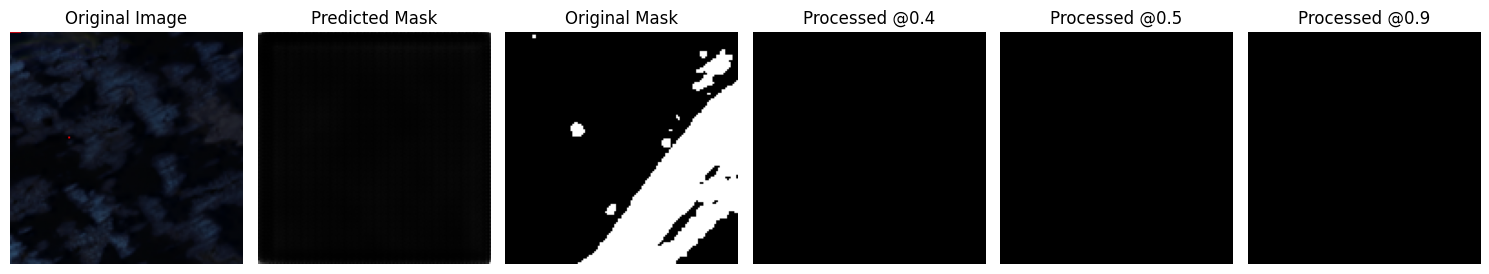

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6970 - loss: 0.0104 - val_accuracy: 0.7268 - val_loss: 0.0091
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - accuracy: 0.6953 - loss: 0.010


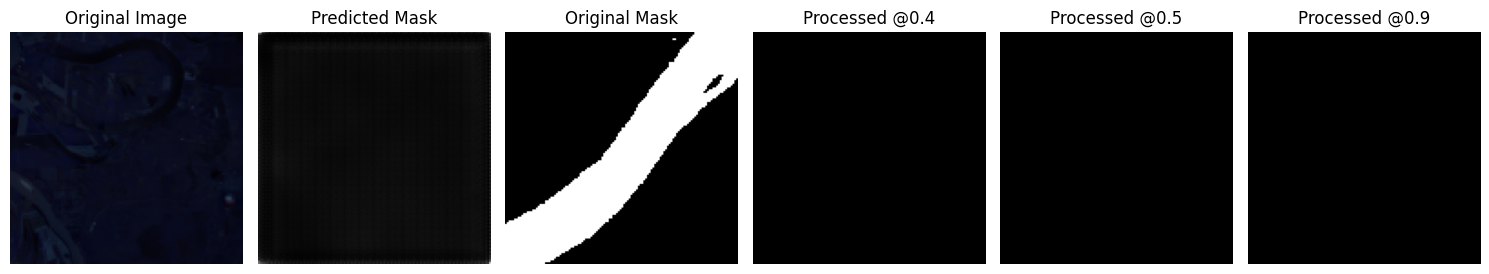

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6946 - loss: 0.0103 - val_accuracy: 0.7268 - val_loss: 0.0118
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepep - accuracy: 0.6772 - loss: 0.011


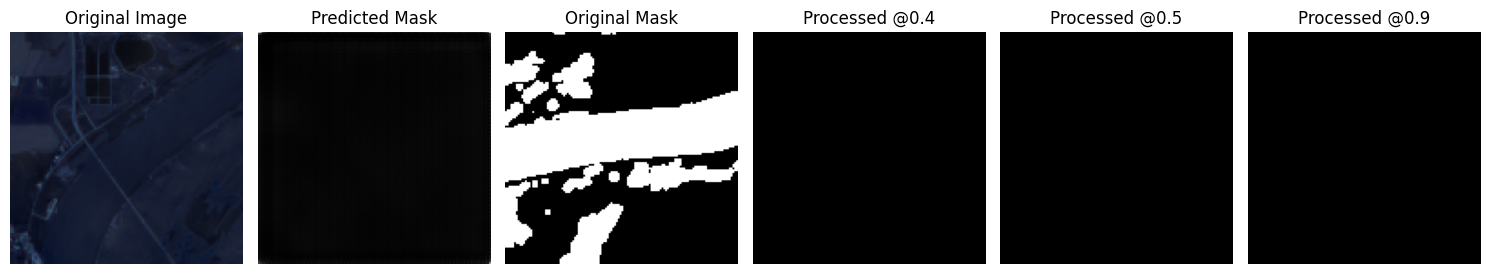

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6776 - loss: 0.0111 - val_accuracy: 0.7268 - val_loss: 0.0093
CPU times: user 1min 4s, sys: 3.88 s, total: 1min 8s
Wall time: 1min 5s


In [19]:

%%time
with tf.device("/GPU:0"):
    results = unet.fit(
        X, y,
        epochs=50,
        callbacks=callbacks,
        validation_split=0.1,
        batch_size=16)

In [20]:
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask, threshold=0.5)
    thresh = float(np.mean(pred_mask) + np.min(pred_mask))
    proc_mask2 = post_process(pred_mask, threshold=thresh)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(15,6))

    plt.subplot(1,5,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,5,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,5,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,5,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,5,5)
    show_image(proc_mask2, title="Processed@{:.2}".format(thresh), cmap='gray')

    plt.tight_layout()
    plt.show()

In [21]:
def post_process(image,threshold):
    return image>threshold

In [22]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [23]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [24]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Adaptive-UNet.keras',save_best_only=True),
    ShowProgress()
]

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/stepaccuracy: 0.4933 - loss: 0.4394


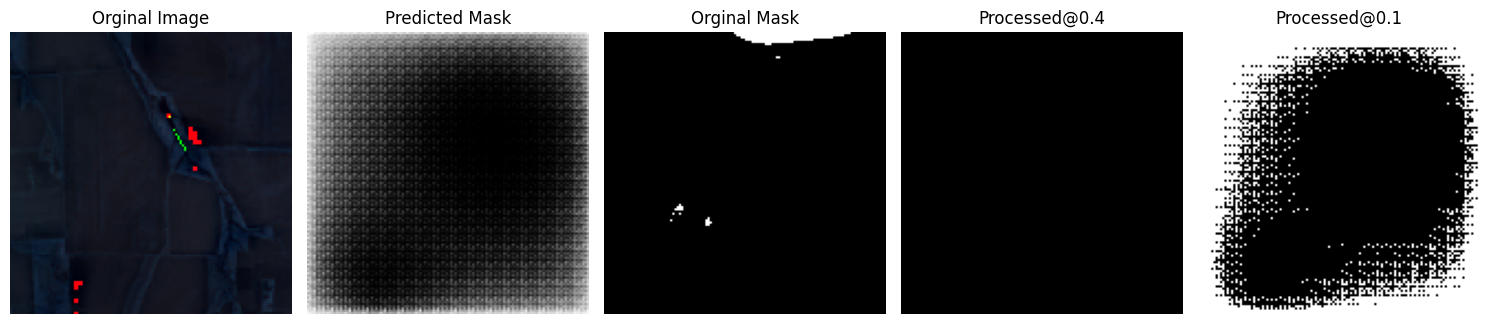

8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5053 - loss: 0.4185 - val_accuracy: 0.7268 - val_loss: 0.1417
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6697 - loss: 0.051


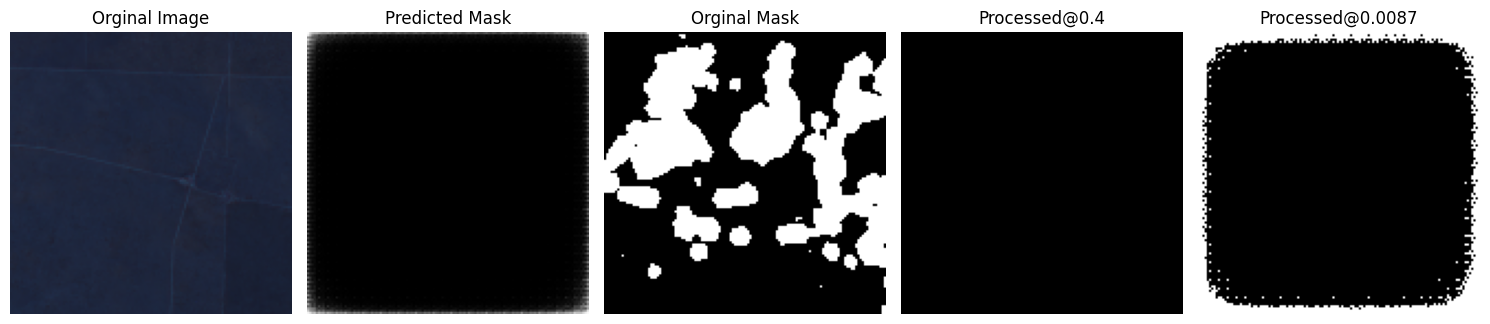

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6729 - loss: 0.0501 - val_accuracy: 0.7268 - val_loss: 0.0221
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6891 - loss: 0.026


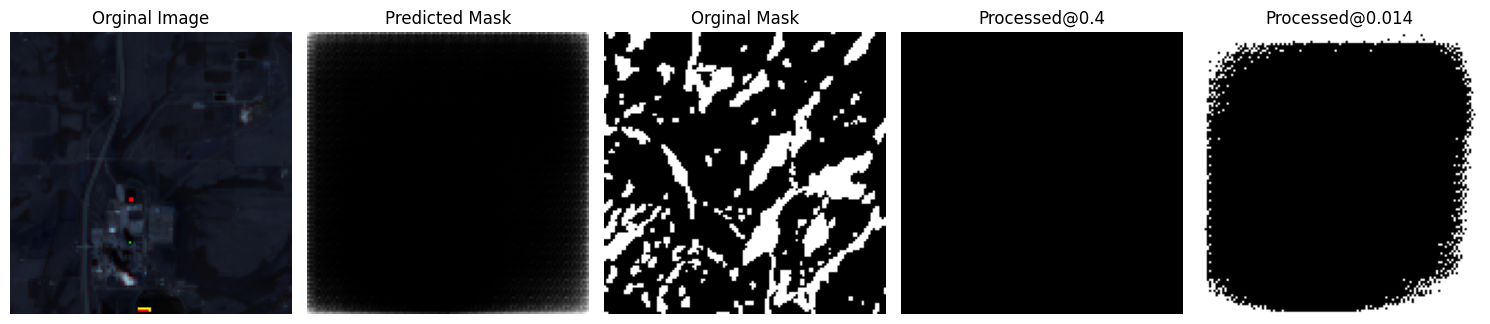

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6880 - loss: 0.0261 - val_accuracy: 0.7268 - val_loss: 0.0242
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6606 - loss: 0.021


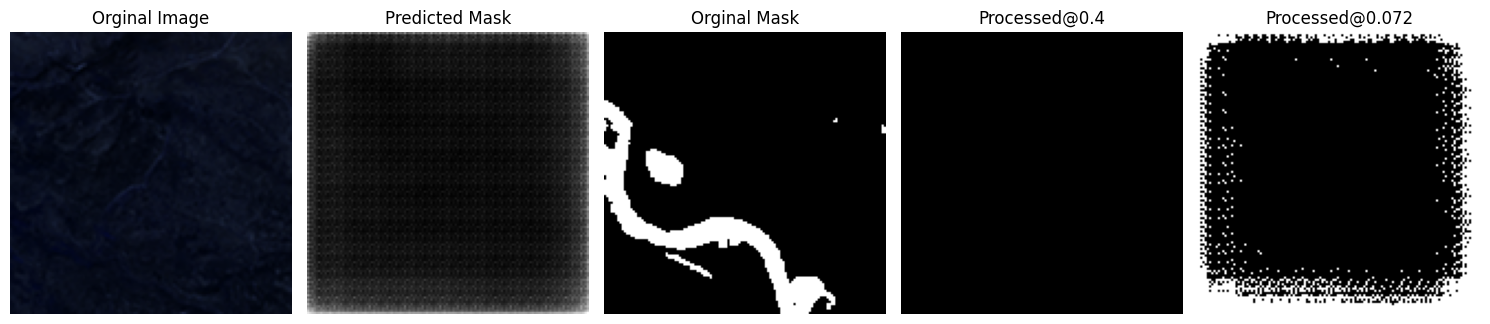

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6658 - loss: 0.0211 - val_accuracy: 0.7268 - val_loss: 0.0353
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6758 - loss: 0.016


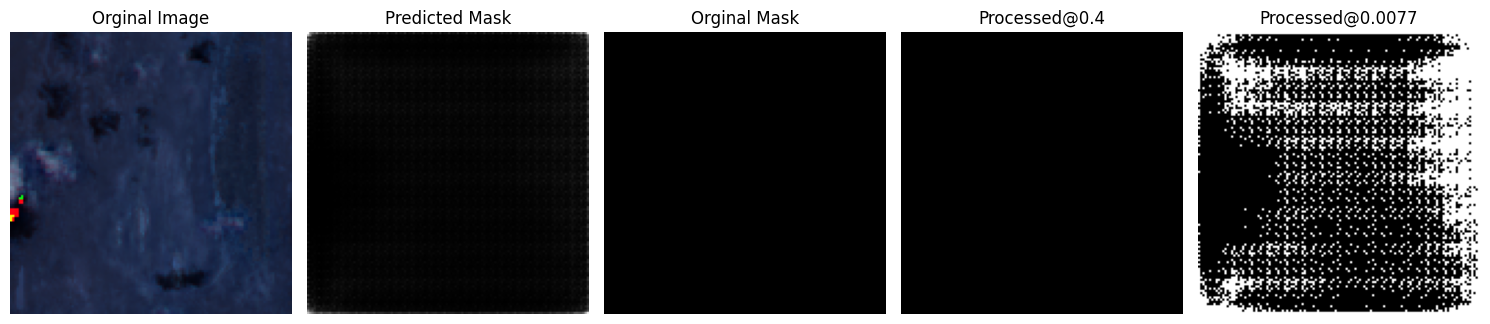

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6776 - loss: 0.0163 - val_accuracy: 0.7268 - val_loss: 0.0267
CPU times: user 52.8 s, sys: 1.9 s, total: 54.7 s
Wall time: 52.5 s


In [25]:
%%time
with tf.device("/GPU:0"):
    results = unet.fit(
        X, y,
        epochs=50,
        callbacks=callbacks,
        validation_split=0.1,
        batch_size=32
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


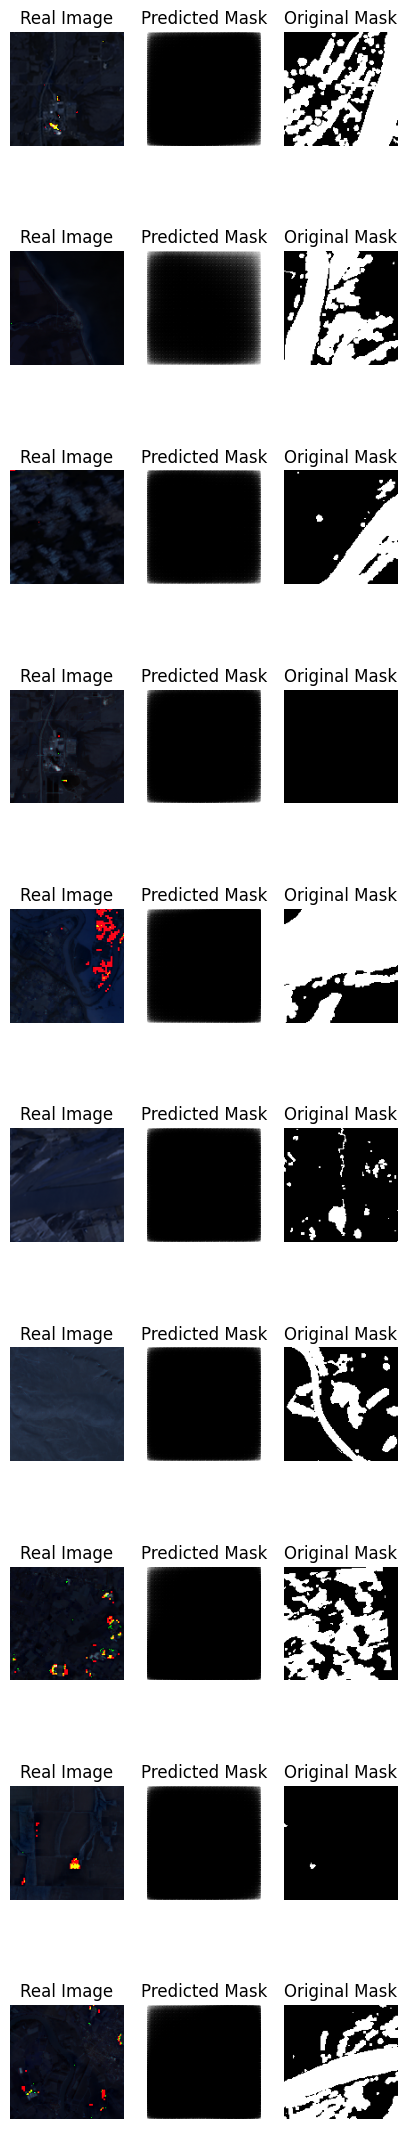

In [26]:
plt.figure(figsize=(5,28))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = unet.predict(real_img).reshape(128,128)
        mask = masks[id].reshape(128,128)
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask", cmap='gray')
        n=0

In [28]:
from keras.metrics import MeanIoU
meanIoU = MeanIoU(num_classes=2)
for image, mask in zip(test_X, test_y):
    pred_mask = unet.predict(image[np.newaxis,...])
    meanIoU.update_state(mask, pred_mask)
print(meanIoU.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━